# Riconoscimento Linee

Ora che abbiamo calibrato la camera possiamo dedicarci al primo e fondamentale passo per un algoritmo di guida autonoma: il **riconoscimento delle linee stradali**.

La città di CheemsCity è caratterizzata da strade nere con linee bianche a segnalarne i bordi e tutte le analisi che andremo a fare adesso si baseranno su questo assunto;  
qual'ora il vostro robot viaggiasse in una città con regole diverse vi basterà cambiare poche cose.

## Matrice Omografica

La **matrice omografica** è un particolare tipo di matrice che ci permette di passare facilmente da un sistema di riferimento ad un altro, ed è molto utile per descrivere rototraslazioni.   
Noi andremo a calcolare la matrice che codifica il passaggio dal sistema di riferimento della foto a quello del mondo reale (da 2D a 3D), in particolare il centro del nuovo sistema di riferimento si troverà nella proiezione sul terreno del centro della fotocamera.

Per poter calcolare la matrice vi occorrerà il foglio con la scacchiera che dovreste aver stampato nel punto precedente.

Come la scorsa lezione partiamo importando le librerie necessarie (il secondo blocco è solo per chi stesse usando una picamera).

In [4]:
import cv2
import time
import numpy as np
import yaml
import glob
import matplotlib.pyplot as plt

In [2]:
#runna solo se stai usando una picamera
from picamera import PiCamera

Andiamo ora ad importare la configurazione calcolata nel foglio precedente.   
**Nota**: *ricordatevi che la matrice omografica è univoca sia per la camera che state usando sia per la dimensione della foto*.

In [ ]:
file = open("part1/FinalCalibration.yml", "r")
calibration_data = yaml.load(file, Loader=yaml.UnsafeLoader)
matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

Calcoliamo quindi una mappa che permetterà di correggere gli errori della camera in modo veloce. Il primo blocco ci servirà solo per calcolare le dimensioni dell'immagine.  
**NOTA**: *mappa è spesso usato come sinonimo di funzione.*

In [ ]:
image = cv2.imread('part1/foto/foto1.jpg')
h, w = image.shape[:2]
print("altezza: {} e w: {}".format(h,w))

altezza: 480 e w: 640


In [ ]:
mapx, mapy = cv2.initUndistortRectifyMap(
                matrix, dist_coef, None, matrix, (w, h), 5)

Creiamo ora una funzione che ci permetterà di sfruttare questa mappa per la correzzione delle immagini.

**TIPS**: *l'utilizzo del try and else ci permette di gestire eventuali problemi, è molto consigliato il suo utilizzo in casi in cui è possibile ricevere valori "non standard" per una funzione o è possibile che un'operazione non vada a buon fine.*

In [ ]:
def undistort_faster(image, mapx, mapy):
    try:
        return cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)
    except:
        return image

Posizioniamo la scaccchiera a terra e mettiamo la camera nell'apposito spazio. Una volta fatto andiamo a definire delle variabili che ne indicheranno la distanza dal punto zero dello scacchiera.

1. **offsety**: distanza lungo l'asse parallelo al lato più vicino della scacchiera.
2. **offsetx**: distanza camera-scacchiera, asse perpendicolare a questa.
3. **camera_calibration_square_size**: dimensione in metri del lato del quadratino della scacchiera.

<div align = "center" >
<img src="part2/chessboard_pos.png">
</div>

In [ ]:
camera_calibration_square_size: 0.018
offsety = 3 * camera_calibration_square_size
offsetx = 0.102 
board_offset = np.array([offsetx, -offsety])
nx = #nx
ny = #ny

E ora come nel caso precedente della calibrazione della camera, sfrutteremo le foto per il calcolo della matrice omogenea. Il vantaggio è che in questo caso ce ne servirà solo una. Il primo blocco è per chi utilizza una picamera, il secondo per quelle USB.

In [15]:
#programma per picamera raspberry pi

camera = PiCamera()
print("avvio camera")
camera.start_preview()
print("foto tra 4 secondi")
time.sleep(4)
photo_name = "part2/omografia.jpg"
camera.capture(photo_name)
camera.stop_preview()
print("foto scattata")

avvio camera
foto tra 4 secondi
foto scattata


In [ ]:
#programma per camera nativa o USB

cam = cv2.VideoCapture(0)
while True:
    print("avvio camera")
    ret, image = cam.read()
	cv2.imshow('photo',image)
	k = cv2.waitKey(1)
    if k == ord(s):
        photo_name = "part2/omografia.jpg"
        cv2.imwrite(photo_name, image)
    if k == ord(q):
		break

Controlliamo che la foto scattata sia valida per la calibrazione, in caso contrario rirunna le celle precedenti. Come nella precedente lezione definiremo valide le foto in cui la funzione **findChessboardCorners** è in grado di riconoscere una scacchiera.

In [ ]:
img = cv2.imread('part2/omografia.jpg')
gray = cv2.cvtColor(img, cv.COLOR_BGR2GRAY)
# Find the chess board corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
if ret == True:
    print("foto buona")
else:
    print("riscattare foto")

Definiamo e cerchiamo i punti necessari per la calibrazione, il metodo sarà lo stesso del foglio precedente se non per il processo di rimozione delle distorsioni della camera pre calcolo dei punti della scacchiera.

**NOTA:** *andiamo ad effetturare un reverse sui punti perchè gli array numpy hanno l'origine in alto a sinistra, mentro noi la vogliamo in basso a sinistra. Questo però ci porterebbe ad avere il punto nella parte alta e sinistra della scacchiera associato con l'ultima coordinata, ottenendo così un'immagine speculare e per questo dovremo andare a moltiplicare la seconda riga della matrice omografica per -1.*

In [ ]:
src_pts = []
for r in range(ny):
    for c in range(nx):
        src_pts.append(
            np.array([r * square_size, c * square_size],
                        dtype='float32') + board_offset)

src_pts.reverse()

imgpoints = []

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
flag = cv2.CALIB_CB_ADAPTIVE_THRESH

rect = undistort_faster(img)
gray = cv2.cvtColor(rect, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (nx,ny), flag)

if ret == True:
    corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    imgpoints.append(corners2)

Procediamo a calcolare la matrice grazie alla funzione di opencv e successivamente salviamola in un file yaml.

In [ ]:
H, _mask = cv2.findHomography(
        imgpoints.reshape(len(imgpoints), 2),
        np.array(src_pts), cv2.RANSAC)

H[1,:] = H[1,:] * -1

In [ ]:
calibration_data = {
    "H_matrix": H
}
with open('part2/Homography.yml', 'w') as outfile:
    yaml.dump(calibration_data, outfile, default_flow_style = False)

## Riconoscimento linee codice ##

Ora che abbiamo la matrice omografica possiamo passare alla parte principale del tutorial; in breve quello che andremo a fare sarà:
1) estrarre tutti i pixel di color bianco dall'immagine.  
2) cercare i punti con gradiente più alto nell'immagine.  
3) intersecare i due risultati per ottenere un riconosciento ottimale.  
4) trovare delle rette nell'immagine risultato.  

Partiamo mostrando tutti i passaggi su un'immagine di prova, e poi andremo a definire una pipeline riutilizzabile per processare immagini real-time

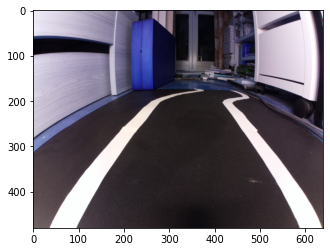

In [61]:
image = cv2.imread("part2/prova.jpg")
plt.imshow(image,cmap='gray')
plt.show()

Andiamo ora ad importare la configurazione standard del foglio precedente; quando creeremo la pipeline personalizzata ricordatevi di usare la vostra.  
**Nota**: *ricordatevi che la matrice omografica è univoca sia per la camera che state usando sia per la dimensione della foto*.

In [5]:
file = open("part1/Calibration160.yml", "r")
calibration_data = yaml.load(file, Loader=yaml.UnsafeLoader)
matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

Calcoliamo la mappa.

In [20]:
image = cv2.imread('part2/prova.jpg')
h, w = image.shape[:2]
print("altezza: {} e w: {}".format(h,w))

altezza: 480 e w: 640


In [21]:
mapxS, mapyS = cv2.initUndistortRectifyMap(
                matrix, dist_coef, None, matrix, (w, h), 5)

Andiamo a rettificare l'immagine utilizzando la funzione definita prima: **undistort_faster**;  
Creeremo poi 2 copie in modo da non andare a modificare direttamente l'immagine di partenza con i filtri.

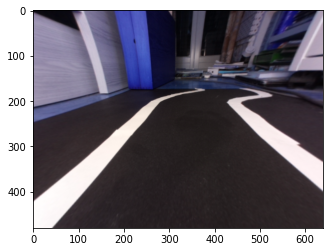

In [26]:
image = undistort_faster(image, mapxS, mapyS)
lane_image = np.copy(image[200:, :, :])
canny_image = np.copy(image[200:, :, :])
plt.imshow(image,cmap='gray')
plt.show()

Sulla prima immagine copiata andremo ad applicare tutti gli algoritmi legati al filtraggio per colore, mentre nella seconda quelli legati alla ricerca di rette.

I colori in digitale sono codificati da varie convenzioni, noi utilizzero quella chiamata [HSV](https://it.wikipedia.org/wiki/Hue_Saturation_Brightness);  
I 3 numeri interi rappresentano **tinta** (H) **saturazione** (S) e **valore** (V).

<div align = "center" >
<img src="part2/hsv.png" width = "30%">
</div>

In [12]:
sens = 100
lower_white = np.array([0, 0, 255 - sens])  #convenzione HSV
upper_white = np.array([255, sens, 255])

Procediamo ora ad isolare i pixel di colore bianco, ottenendo così una matrice con le stesse dimensioni dell'immagine e valore True dove presente i pixel bianchi.

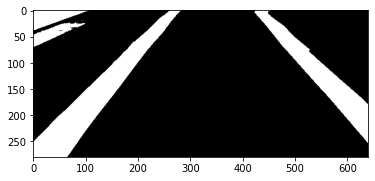

In [25]:
frameHSV = cv2.cvtColor(lane_image, cv2.COLOR_BGR2HSV)
frameHSV = cv2.inRange(frameHSV, lower_white, upper_white)
plt.imshow(frameHSV,cmap='gray')
plt.show()

Per evitare di trovarci con linee spezzate o bucate utilizziamo una trasformazione morfologica basata su un kernel 3x3 chiamata [dilate]('https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html').


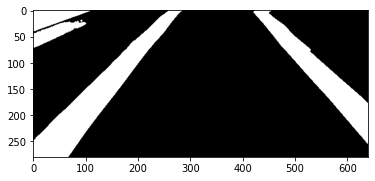

In [28]:
#STEP 3: chiudere eventuali buchi con un dilate:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
frameHSV = cv2.dilate(frameHSV, kernel)
plt.imshow(frameHSV,cmap='gray')
plt.show()

Andiamo ora ad applicare l'algoritmo [canny]('https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html') sulla seconda immagine. Questo è un popolare algoritmo "multi-stadio" che va a studiare il gradiente dell'immagine e isola i punti con valore più alto.

In [29]:
edges = cv2.Canny(canny_image, 80, 200, apertureSize=3)

Uniamo ora i due risultati -> le 2 immagini saranno infatti caratterizzate da 2 colori (bianco e nero, True o False) e sarà quindi possibile eseguire un'operazione di intersezione tra queste.

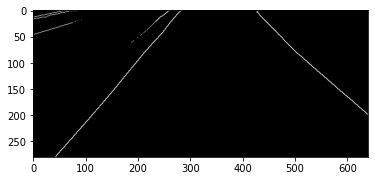

In [30]:
edge_color = cv2.bitwise_and(frameHSV, edges)
plt.imshow(edge_color,cmap='gray')
plt.show()

Cerchiamo ora delle rette nell'immagine attraverso l'algoritmo [Hough]('https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html'). Spiegare anche brevemente parametri.

In [32]:
lines = cv2.HoughLinesP(edge_color,
                        rho=1,
                        theta=np.pi / 180,
                        threshold=2,
                        minLineLength=3,
                        maxLineGap=1,
                        lines=np.array([]))

Ora abbiamo un insieme di punti legati alle rette trovate dall'algoritmo Hough, questi punti saranno definiti nel sistema di riferimento dell'immagine. Per un ottimo controllo di un eventuale veicolo sarà bene trasformarle nel sistema di riferimento del robot tramite la matrice omografica.

L'algoritmo Hough ritornerà un array nX4, composto quindi da n righe di valori x1,y1,x2,y2. Quello che facciamo è dividere i 4 punti in 2 array, il primo contenente solo i punti 1 (x1,y1), il secondo solo quelli 2. Come ultimo passaggio aggiungiamo il primo array ad una lista contenente tutti i punti 1 e il secondi ad una lista contenente tutti i punti 2.

In [35]:
road_points_p1 = []
road_points_p2 = []

if lines is not None:
    for line in lines:
        p1, p2 = line.reshape(2, 2)
        road_points_p1.append(p1)
        road_points_p2.append(p2)

Per poter lavorare più facilmente con i punti trasformiamo le liste in array numpy.

In [36]:
road_vec1 = np.array(road_points_p1, ndmin=2)
road_vec2 = np.array(road_points_p2, ndmin=2)

Rappresentiamo ora le linee trovate nell'immagine.

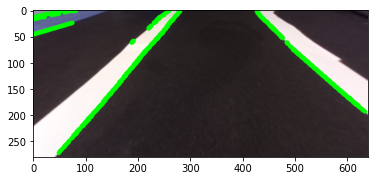

In [62]:
line_thickness = 7
for a in range(road_vec1[:,0].size):
    c1 = (road_vec1[a,0],road_vec1[a,1])
    c2 = (road_vec2[a,0],road_vec2[a,1])
    cv2.line(lane_image, c1,c2, (0, 255, 0), thickness=line_thickness)
plt.imshow(lane_image,cmap='gray')
plt.show()

Ricordiamo che i punti sono stati calcolati su un'immagine tagliata, per garantire quindi la veridicità della trasformazione dovrò aggiungere l'altezza del pezzo tagliato ai valori dell'altezza dei punti. Questo verrà fatto creando un array (0,h) e sommandolo agli array dei punti.

In [63]:
roi_h = 200
roi_vect = np.array((0, roi_h))

road_vec1 = (road_vec1 + roi_vect)
road_vec2 = (road_vec2 + roi_vect)

definiamo ora una funzione sky_view_points per il calcolo di questi.

In [64]:

    def sky_view_points(points, H):
        vector = np.append(points, np.array([1]))
        ground_point = np.dot(H, vector)
        x = ground_point[0]
        y = ground_point[1]
        z = ground_point[2]

        skyPoints = np.array([(y / z), (x / z)])
        return skyPoints

Andiamo ad utilizzare la matrice omografica standard associata alla camera prova (quella che ha scattato la foto che stiamo usando).

In [85]:
file = open("part2/homographyS.yml", "r")
calibration_data = yaml.load(file, Loader=yaml.UnsafeLoader)
H = calibration_data['H_matrix']

creiamo due nuove liste contenente i valori dei punti ma post trasformazione omografica. Come prima procediamo poi a trasformarla in un array numpy.

In [86]:
numPoints = road_vec1.shape[0] if road_vec1.shape[1] == 2 else 0
sky_list1 = []
sky_list2 = []
for i in range(numPoints):
    sky_list1.append(sky_view_points(road_vec1[i, :], H))
    sky_list2.append(sky_view_points(road_vec2[i, :], H))

In [87]:
sky_points1 = np.array(sky_list1, ndmin=2)
sky_points2 = np.array(sky_list2, ndmin=2)

Vediamo ora come questi punti sono disposti e se veramente rappresentano la forma della strada. Mostriamo a schermo anche un secondo punto particolare che rappresenterà l'andamento orizzontale della strada.

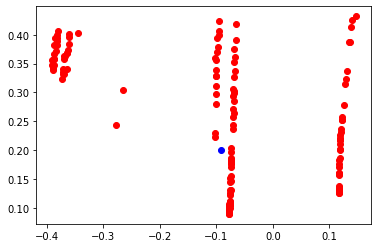

In [88]:
points = np.vstack([sky_points1, sky_points2])
PPpoint = [np.mean(points[:, 0], axis=0), 0.2]

plt.plot(points[:, 0], points[:, 1], 'ro')
plt.plot(PPpoint[0], PPpoint[1], 'bo')
plt.show()

notiamo come la strada sia ben rappresentata. Si può inoltre osservare sulla sinitra, a circa 40 cm di distanza orizzontale dal robot, del "rumore", ovvero parti dell'immagine che il nostro programma ha riconosciuto erroneamente per linee. Questo può essere sistemato andando a modificare il range del colore di riconoscimento.

**TO-DO:** provate a modificare il range di riconoscimento del colore dellle linee per far sparire il rumore!